<a href="https://colab.research.google.com/github/mohamed-ayeb-97/Spark_Apach/blob/main/Spark_Apach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mini-TP sur Apache Spark**




##**1. Objectifs**

Le TP consiste à regrouper des documents textuels tels que les documents qui
partagent le même thème se retrouvent dans le même groupe, et les documents qui
portent sur des sujets très différents se trouvent dans des groupes différents.


## **2. Mise en place de l'environnement de travail**

In [ ]:
! sudo apt-get update
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,013 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:14 http://ppa.launchpad.net/graph

In [ ]:
! wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

In [ ]:
! tar xf /content/spark-3.3.2-bin-hadoop3.tgz

In [ ]:
!pip install -q findspark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 24.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=721ca50e90249705940e35e8a483794fd15f3a47ed2ce36f6d0f91b1c400da5d
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [ ]:
# Set up required environment variables

import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.5 pyspark-shell'

import findspark

findspark.init("spark-3.3.2-bin-hadoop3")


from pyspark import SparkContext, SparkConf


configuration = SparkConf().setAppName("name").setMaster("local[4]")
sc = SparkContext(conf=configuration)

In [ ]:
sc

<SparkContext master=local[4] appName=name>

## **3. Données**

In [ ]:
# Telechargement des données

! wget -q http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz

In [ ]:
# Decompression des données

! tar xf /content/20news-19997.tar.gz

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config(conf=configuration).getOrCreate()

In [ ]:
# Chargement des données dans deux variables de type RDD

rdd_alt_atheism = sc.wholeTextFiles("/content/20_newsgroups/alt.atheism")
rdd_rec_sport_baseball = sc.wholeTextFiles("/content/20_newsgroups/rec.sport.baseball")

In [ ]:
# Split_header_body est la fonction qu'on va utliser pour séparer le corps du message de l’entête

def split_header_body(document):
    # Séparer le document à la première occurrence de "\n\n"
    header, body = document.split("\n\n", 1)
    return header,body

# org_cat est la fonction qu'on va utliser pour extraire les champs de l'entête (l'organisation & la catégorie)

def org_cat(x):
  lines = x.split('\n')
  org_name = 'None'
  cat_name = 'None'
  for line in lines:
    if line.startswith('Organization:'):
      org_name = line.split(':')[1].strip()
    # dans cette partie de la fonction on a utlisé la méthode ci-dessous pour contourner le problème d'apparition d'autres mots non essentiels dans la catégorie
    if line.startswith('Newsgroups:'):
      if "alt.atheism" in line:
        cat_name = "alt.atheism"
      if "rec.sport.baseball" in line:
        cat_name = "rec.sport.baseball"

  return (cat_name,org_name)

# Appliquer la fonction à chaque document de chaque RDD

rdd_alt_atheism = rdd_alt_atheism.map(lambda x: split_header_body(x[1]))
rdd_rec_sport_baseball = rdd_rec_sport_baseball.map(lambda x: split_header_body(x[1]))


rdd_alt_atheism = rdd_alt_atheism.map( lambda x: org_cat(x[0]) + (x[1],) )
rdd_rec_sport_baseball = rdd_rec_sport_baseball.map( lambda x: org_cat(x[0]) + (x[1],) )

In [ ]:
rdd_alt_atheism.collect()[2]

('alt.atheism',
 'Summit NJ',
 'student writes:\n\n>Somewhere, roger colin shouse writes about "radical gay dogma."  Somewhere else\n>he claims not to claim to have a claim to knowing those he doesn\'t know.\n>There are at least twenty instances of this kind of muddleheaded fourth-\n>reich-sophistique shit in his postings.  Maybe more.  In fact I\'m not sure\n>the instances could be counted, because they reproduce like a virus the more\n>you consider his words.\n>\tMy question is this: what is the best response to weasels like\n>shouse and Stan Krieger?  Possibilities:\n>\t(a) study them dispassionately and figure out how they work, then\n>(1) remember what you\'ve learned so as to combat them when they or their clones\n>get into office\n>(2) contribute your insights to your favorite abnormal psych ward\n>\t(b) learn to overcome your repugnance for serial murder\n\nThis posting is totally uncalled for in rec.scouting.\n\nThe point has been raised and has been answered.  Roger and I hav

In [ ]:
# Fusionnement des deux RDD avec un union

union_rdd = rdd_alt_atheism.union(rdd_rec_sport_baseball)


In [ ]:
# Transformation du nouveau RDD obtenu pour que chaque élément doit de type pyspark.sql.Row

from pyspark.sql import Row

union_rdd = union_rdd.map(lambda x: Row(categorie = x[0], organisation=x[1], message = x[2]))


In [ ]:
# Creation d'un objet de type DataFrame à partir du RDD précédent

df = spark.createDataFrame(union_rdd, schema=['Categorie', 'Organisation', 'Message'])

df.show()

+-----------+--------------------+--------------------+
|  Categorie|        Organisation|             Message|
+-----------+--------------------+--------------------+
|alt.atheism|                   -|In article <1pmjo...|
|alt.atheism|California Instit...|(reference line t...|
|alt.atheism|           Summit NJ|student writes:\n...|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|
|alt.atheism|CS Dept, Universi...|-*-----\nIn artic...|
|alt.atheism|Society for Putti...|bil@okcforum.osrh...|
|alt.atheism|Boston University...|In article <1qlb7...|
|alt.atheism|Case Western Rese...|In article <1993A...|
|alt.atheism|        SGI TechPubs|---\n[I'm taking ...|
|alt.atheism|Computing Laborat...|\nacooper@mac.cc....|
|alt.atheism|Boston University...|In article <1993A...|
|alt.atheism|California Instit...|arromdee@jyusenky...|
|alt.atheism|I didn't do it, n...|In article <4963@...|
|alt.atheism|University of Wis...|[reply to fran

In [ ]:
df.describe().show()

+-------+------------------+-------------+--------------------+
|summary|         Categorie| Organisation|             Message|
+-------+------------------+-------------+--------------------+
|  count|              2000|         2000|                2000|
|   mean|              null|         null|                null|
| stddev|              null|         null|                null|
|    min|       alt.atheism|   'Operation|\t     MLB Standi...|
|    max|rec.sport.baseball|worldbank.org||> >|> \n|> >|> H...|
+-------+------------------+-------------+--------------------+



In [ ]:
!pip install fastavro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.6 MB/s eta 0:00:00


In [ ]:
# Sauvgarde de la DataFrame au format Avro

import fastavro
from fastavro import writer

# Conversion de la DataFrame sous forme de liste de dictionaires

records = df.collect()
data = [r.asDict() for r in records]

# Definition du schéma Avro schema pour les données
schema = {
    "type": "record",
    "name": "people",
    "fields": [
        {"name": "Categorie", "type": "string"},
        {"name": "Organisation", "type": "string"},
        {"name": "Message", "type": "string"}
    ]
}

# Sauvgarde des données dans un fichier avro
with open("/content/df_avro.avro", "wb") as out:
    fastavro.writer(out, schema, data)

In [ ]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Sauvgardee de la DataFrame au format Parquet

import pyarrow as pa
import pyarrow.parquet as pq


table = pa.Table.from_pandas(df.toPandas())
pq.write_table(table, '/content/df_parquet.parquet')

## **4. Analyse descriptive**

L'objectif de cette partie est de faire une analyse descriptive de la DataFrame obtenue à l’étape précédente en utilisant l'API Spark SQL.

In [ ]:
# Enregistrement de la DataFrame comme une vue temporaire
df.createOrReplaceTempView("documents")

# Vérification qu'on a bien deux catégories différentes de documents

distinct_categories = spark.sql("SELECT DISTINCT Categorie FROM documents")
distinct_categories.show()

# Le nombre d'organisations différentes

organisation_count = spark.sql("SELECT COUNT(DISTINCT Organisation) FROM documents")
organisation_count.show()

# Statistiques descriptives des données
df.describe().show()

+------------------+
|         Categorie|
+------------------+
|       alt.atheism|
|rec.sport.baseball|
+------------------+

+----------------------------+
|count(DISTINCT Organisation)|
+----------------------------+
|                         483|
+----------------------------+

+-------+------------------+-------------+--------------------+
|summary|         Categorie| Organisation|             Message|
+-------+------------------+-------------+--------------------+
|  count|              2000|         2000|                2000|
|   mean|              null|         null|                null|
| stddev|              null|         null|                null|
|    min|       alt.atheism|   'Operation|\t     MLB Standi...|
|    max|rec.sport.baseball|worldbank.org||> >|> \n|> >|> H...|
+-------+------------------+-------------+--------------------+



## **5. Transformation du texte**

L'objectif de cette partie est d'effectuer un prétraitement sur le texte qu'on avant d'appliquer l'algorithme KMeans.

In [ ]:
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF, Normalizer

# Création d'un objet Tokenizer

#On a utilisé ici RegexTokenizer pour n'extraire que les mots non pas les caractères spéciaux

tokenizer = RegexTokenizer(inputCol="Message", outputCol="words", pattern="[^\w]+")

# Application le tokenizer aux données
tokenized_data = tokenizer.transform(df)

# Affichage des résultats
tokenized_data.show()


+-----------+--------------------+--------------------+--------------------+
|  Categorie|        Organisation|             Message|               words|
+-----------+--------------------+--------------------+--------------------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|
|alt.atheism|CS Dept, Universi...|-*-----\nIn artic...|[in, article, 1r6...|
|alt.atheism|Society for Putti...|bil@okcforum.osrh...|[bil, okcforum, o...|
|alt.atheism|Boston University...|In article <1qlb7...|[in, article, 1ql...|
|alt.atheism|Case Western Rese...|In article <1993A...|[in, article, 199...|
|alt.atheism|        SGI TechPubs|---\n[I'm taking ...|[i, m, taking, ta...|

In [ ]:
# Création d'une représentation vectorielle des documents à l'aide de HashingTF

# Création d'un objet HashingTF

hashingTF = HashingTF(numFeatures=50, inputCol="words", outputCol="features")

# Application du  HashingTF aux données tokenizées
hashed_data = hashingTF.transform(tokenized_data)

# Afficher les résultats
hashed_data.show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|  Categorie|        Organisation|             Message|               words|            features|
+-----------+--------------------+--------------------+--------------------+--------------------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|(50,[0,1,2,3,4,5,...|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|(50,[0,1,2,3,4,5,...|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|(50,[1,3,4,5,6,8,...|
|alt.atheism|CS Dept, Universi...|-*-----\nIn artic...|[in, article, 1r6...|(50,[0,1,2,3,4,5,...|
|alt.atheism|Society for Putti...|bil@okcforum.osrh...|[bil, okcforum, o...|(50,[0,1,2,3,4,5,...|
|alt.atheism|Boston 

## **6. Groupement des documents qui ont des représentations vectorielles proches**

In [ ]:
# Utilisation de l'algorithme KMeans avec un nombre du cluster égal 2

from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(hashed_data.select('features'))
predictions = model.transform(hashed_data)
predictions.show()

+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|  Categorie|        Organisation|             Message|               words|            features|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+----------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|(50,[0,1,2,3,4,5,...|         0|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|(50,[0,1,3,4,5,6,...|         0|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|(50,[0,1,3,4,5,6,...|         0|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|(50,[0,1,2,3,4,5,...|         0|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|(50,[1,3,4,5,6,8,...|         0|
|alt.atheism|CS Dept, Universi...|-*-----\nIn artic...|[in, article, 1r6...|(50,[0,1,2,3,4,5,...|         0|
|alt.atheism|Societ

<font color='red'>**Le score WSSSE**</font>  (Within Set Sum of Squared Errors) est une métrique utilisée pour évaluer la qualité de la clustering, qui mesure la somme des carrés des distances entre chaque point d'un cluster et le centre de ce cluster. Plus précisément, pour chaque cluster, le score WSSSE calcule la somme des distances au carré entre chaque point du cluster et le centre du cluster, et somme ensuite ces valeurs pour tous les clusters. L'objectif est de minimiser le score WSSSE, ce qui correspond à avoir des clusters bien séparés et cohérents.

In [ ]:
#Calcul du score WSSSE
wssse = model.summary.trainingCost

# Affichage du WSSSE
print("Within-Set Sum of Squared Errors = {:.2f}".format(wssse))

Within-Set Sum of Squared Errors = 6814008.58


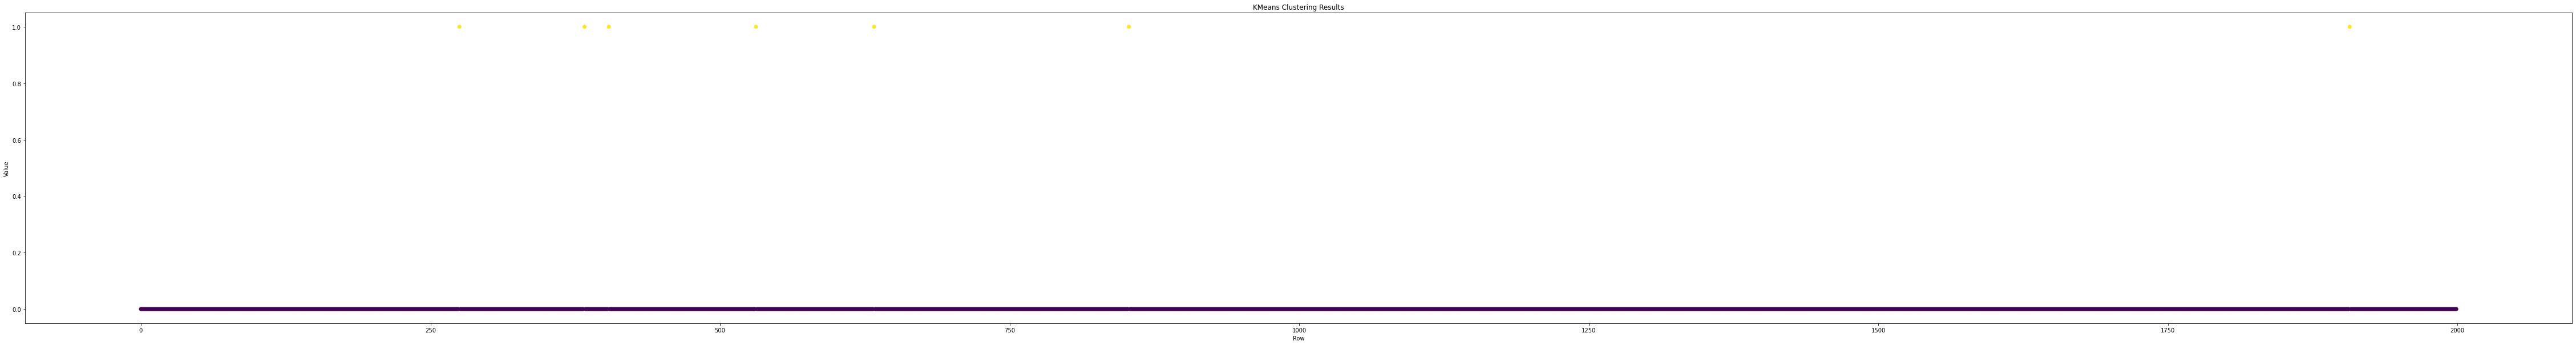

In [ ]:
import matplotlib.pyplot as plt
data = predictions.select("prediction").toPandas()
fig, ax= plt.subplots(figsize=(80,10))
plt.scatter(range(len(data)), data["prediction"], c=data["prediction"])
plt.title("KMeans Clustering Results")
plt.xlabel("Row")
plt.ylabel("Value")
plt.show()


<font color='red'>**Remarque:**</font> On observe que l'algorithme KMeans n'a pas réussi à trouver les deux catégories qu'on a.

## **7. Pour aller plus loin**

In [ ]:
idf = IDF(inputCol="features", outputCol="features_1")
idfModel = idf.fit(hashed_data)
rescaledData = idfModel.transform(hashed_data)
rescaledData.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Categorie|        Organisation|             Message|               words|            features|          features_1|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|(50,[1,3,4,5,6,8,...|(50,[1,3,4,5,6,8,...|
|alt.atheism|CS Dept, Universi...|-*-----\nIn ar

In [ ]:
# Ici on supprimé la colonne features ancienne du KMeans précedent pour en faire une nouvelle du nouveau KMeans
rescaledData = rescaledData.drop("features")

normalizer = Normalizer(inputCol="features_1", outputCol="features")
normalizedData = normalizer.transform(rescaledData)
normalizedData.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  Categorie|        Organisation|             Message|               words|          features_1|            features|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|(50,[1,3,4,5,6,8,...|(50,[1,3,4,5,6,8,...|
|alt.atheism|CS Dept, Universi...|-*-----\nIn ar

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=2, seed=1)
model_2 = kmeans.fit(normalizedData.select('features'))
predictions_2 = model_2.transform(normalizedData)
predictions_2.show()

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  Categorie|        Organisation|             Message|               words|          features_1|            features|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|alt.atheism|                   -|In article <1pmjo...|[in, article, 1pm...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|         0|
|alt.atheism|California Instit...|(reference line t...|[reference, line,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|         0|
|alt.atheism|           Summit NJ|student writes:\n...|[student, writes,...|(50,[0,1,3,4,5,6,...|(50,[0,1,3,4,5,6,...|         0|
|alt.atheism|Mantis Consultant...|watson@sce.carlet...|[watson, sce, car...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|         0|
|alt.atheism|Okcforum Unix Use...|Keith M. Ryan (km...|[keith, m, ryan, ...|(50,[1,3,4,5,6

In [ ]:
wssse = model_2.summary.trainingCost

# Print the WSSSE
print("Within-Set Sum of Squared Errors = {:.2f}".format(wssse))

Within-Set Sum of Squared Errors = 730.17


<font color='red'>**Remarque:**</font> On remarque que le score c'est amélioré.

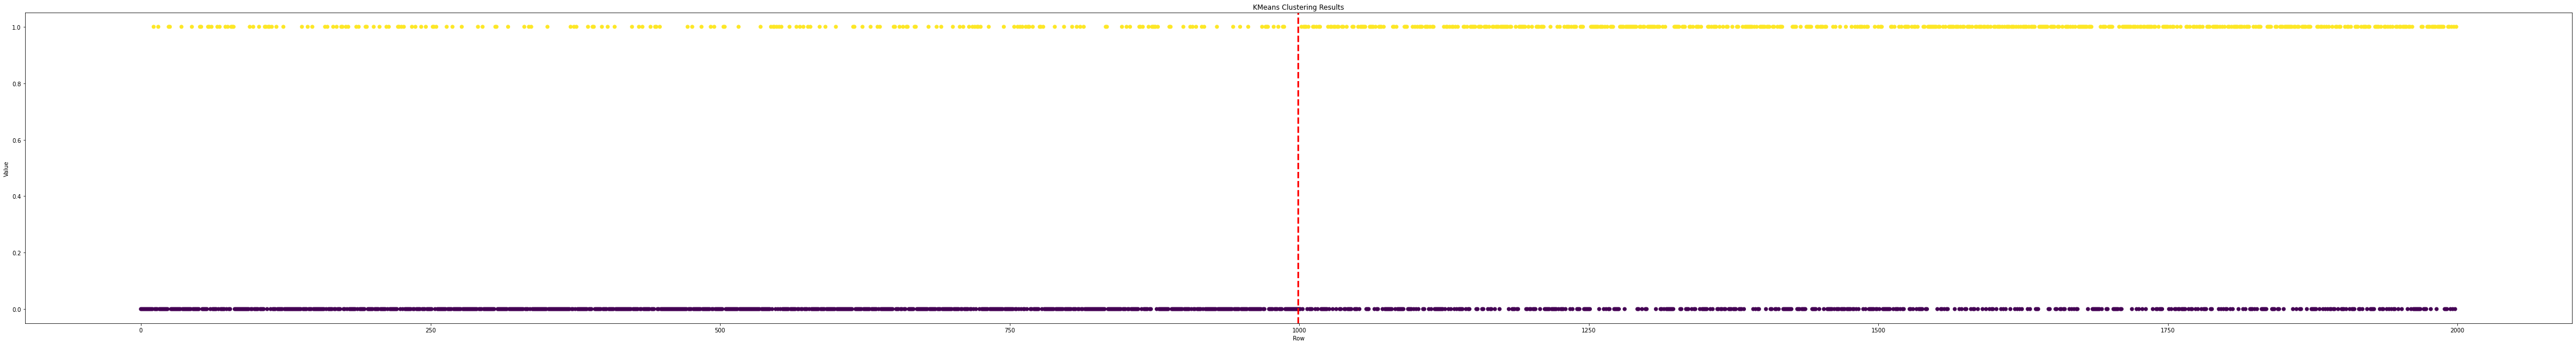

In [ ]:
data = predictions_2.select("prediction").toPandas()

fig, ax = plt.subplots(figsize=(80, 10))
plt.scatter(range(len(data)), data["prediction"], c=data["prediction"])
ax.axvline(x=999, color='r', linestyle='--', linewidth=3)
plt.title("KMeans Clustering Results")
plt.xlabel("Row")
plt.ylabel("Value")
plt.show()



<font color='red'>**Remarque:**</font> On observe que le résultat de classification s'est amélioré, car on remarque qu'il commence un peu à distinguer les deux catégories (points mauve concentré à gauche et point jaunes concentrés à droite). Mais ça reste insuffisant.

##**Conclusion:**
En conclusion, ce TP sur Apache Spark nous a permis de découvrir et de mettre en pratique différentes fonctionnalités de Spark pour le traitement de données textuelles. Nous avons appris à charger des données textuelles dans Spark, à les nettoyer et à les transformer pour l'analyse. Nous avons également utilisé Spark SQL et MlLib pour effectuer des analyses descriptives et des regroupements de documents similaires à l'aide de l'algorithme KMeans. Enfin, nous avons vu des options avancées telles que la pondération Tf-Idf et la normalisation des vecteurs avant l'utilisation de l'algorithme KMeans. Ce TP nous a donc permis de comprendre comment utiliser Spark pour le traitement et l'analyse de données textuelles de manière efficace et évolutive.